# Dataset background information

Telco customer churn dataset:

The Telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index.

## Data-dictionary

Each row represents a customer, each column contains customer’s attributes.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


# Objective of analysis
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs."  The benefit of this analysis will be keeping the old customers renewing program to increase the customer lifetime value (CLV).

So in our modelling, we have to locate & approach the churned customers before they perform churning action. 

This dataset is detailed in:
https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

In [2]:
# Import Libraries needed to load the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns 
import sklearn
from sklearn.linear_model import LogisticRegression
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [3]:
# import files & check out the details

data = pd.read_csv('data/Telco_Customer_Churn.csv')
print(data.shape)
print(data.head())
print(data.dtypes)

(7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Co

# Table of contents for analysis

In this analysis, we will first conduct 

    1. Feature engineeering
    2. EDA
    3. Pre-processing
    4. StratifiedShuffle train-test-Spli
    5. logistics regresssion
    6. K-nearest neighbour
    7. Support vector machine
    8. model evaluation & insights

## Feature engineering

### change datatype of "TotalCharges" from object to float

In [3]:
# change datatype of "TotalCharges" from object to float

# find the missing values - by null
print(data.TotalCharges.isnull().sum())

# find the missing values - by empty string
print(data.TotalCharges.str.isspace().sum())

0
11


In [4]:
# trim the empty string
data.TotalCharges = data.TotalCharges.str.strip()

# change datatype
data['TotalCharges'] = pd.to_numeric(data.TotalCharges)

### checking for missing values

In [5]:
# find the missing values - by null
print(data.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [6]:
# remove rorws with missing values
data = data.dropna().reset_index(drop=True)

### dropping meaningless column (e.g. customerID)

In [7]:
# for object features, filtering for meaningful variables (remove column with unique values e.g. customerID)
data.nunique()

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

In [8]:
# drop customerID before one-hot encoding
data = data.drop(['customerID'], axis=1)

### 1/0 transformation for target variable -- Churn

In [9]:
# change from yes/no to 1/0 for target column
data['Churn'] = data.Churn.apply(lambda x: 1 if x == 'Yes' else 0)

In [10]:
data['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

### One-hot encoding for categorical variables:

In [11]:
# showing datatypes summary of all columns
data.dtypes.value_counts()

object     15
int64       3
float64     2
dtype: int64

There are 16 categorical features which potentially needs one-hot encoding. 

In [12]:
# getting list of object column
obj_col_list = data.dtypes[data.dtypes == np.object].index.tolist() 

In [13]:
# one hot encoding
data_oh = pd.get_dummies(data, columns = obj_col_list ,drop_first=False)
print(data_oh.head())

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Female  \
0              0       1           29.85         29.85      0              1   
1              0      34           56.95       1889.50      0              0   
2              0       2           53.85        108.15      1              0   
3              0      45           42.30       1840.75      0              0   
4              0       2           70.70        151.65      1              1   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  ...  \
0            0           0            1              1  ...   
1            1           1            0              1  ...   
2            1           1            0              1  ...   
3            1           1            0              1  ...   
4            0           1            0              1  ...   

   StreamingMovies_Yes  Contract_Month-to-month  Contract_One year  \
0                    0                        1                  0   


## EDA

To investigate feature relationship, also the potential colliearity between features, we first conduct correlation analysis before any modelling.

Now, as the features columns increase to 30 columns which is a lot greater than before. We would like to visualize the correlation distribution & check if any pairs of features having high correlation (corrrelation > 0.8 either positively or negatively)


In [14]:
### BEGIN SOLUTION
# Calculate the correlation values
corr_values = data_oh.corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

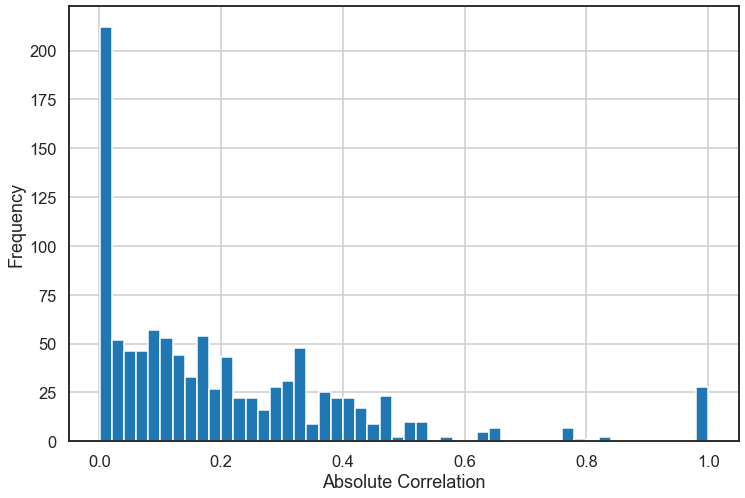

In [15]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [16]:
# The most highly correlated values
corr_values.sort_values('abs_correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
215,gender_Female,gender_Male,-1.000000,1.000000
475,PhoneService_Yes,MultipleLines_No phone service,-1.000000,1.000000
369,Dependents_No,Dependents_Yes,-1.000000,1.000000
440,PhoneService_No,PhoneService_Yes,-1.000000,1.000000
790,OnlineBackup_No internet service,StreamingTV_No internet service,1.000000,1.000000
712,OnlineSecurity_No internet service,OnlineBackup_No internet service,1.000000,1.000000
784,OnlineBackup_No internet service,DeviceProtection_No internet service,1.000000,1.000000
904,TechSupport_No internet service,StreamingMovies_No internet service,1.000000,1.000000
946,StreamingTV_No internet service,StreamingMovies_No internet service,1.000000,1.000000
661,InternetService_No,OnlineBackup_No internet service,1.000000,1.000000


The pairs showing correlation value = 1 are mostly rule-based between features (e.g. StreamingTV_No internet service = StreamingMovies_No internet service), 

while "tenure & total charges" having correlation 0.82. It is in common sense that the longer you subscribe a service, the more money you paid thoughtout the whole period. 

In [17]:
# The most highly correlated values with target variable - Churn
corr_values.sort_values('abs_correlation', ascending=False).query('feature1 == "Churn"')

,feature1,feature2,correlation,abs_correlation
206,Churn,Contract_Month-to-month,0.404565,0.404565
188,Churn,OnlineSecurity_No,0.342235,0.342235
197,Churn,TechSupport_No,0.336877,0.336877
186,Churn,InternetService_Fiber optic,0.307463,0.307463
208,Churn,Contract_Two year,-0.301552,0.301552
213,Churn,PaymentMethod_Electronic check,0.301455,0.301455
191,Churn,OnlineBackup_No,0.267595,0.267595
194,Churn,DeviceProtection_No,0.252056,0.252056
198,Churn,TechSupport_No internet service,-0.227578,0.227578
201,Churn,StreamingTV_No internet service,-0.227578,0.227578


The highest correlation with features is with 0.4. Showing customers with service of "Contract_Month-to-month" will probably churn.

We then proceed to modelling to validate our hypothesis.

## Pre-processing

For column not in 1/0 (i.e.  'tenure','MonthlyCharges','TotalCharges' ) , we conduct min-max scaling for these.

In [18]:
# features columns
cols_without_target =  ['Churn'] 
cols_with_target = ['Churn']

# exclude column1, column2, ...
feature_df = data_oh.loc[:, ~data_oh.columns.isin(cols_without_target)]
target_df = data_oh.loc[:, data_oh.columns.isin(cols_with_target)]

In [19]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

for column in ['tenure','MonthlyCharges','TotalCharges' ]:
    feature_df[column] = mm.fit_transform(feature_df[[column]])

## StratifiedShuffle train-test-Split

In [20]:
## performing train-test split
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(feature_df, target_df))

# Create the dataframes
X_train = feature_df.loc[train_idx, :]
y_train = target_df.loc[train_idx]

X_test  = feature_df.loc[test_idx, :]
y_test  = target_df.loc[test_idx]

In [21]:
### resampling to have the balanced dataset -- Churn: not churn = 50:50  from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

KNN & SVM are highly deviated by imbalanced dataset. We have to resample the dataset, making our target variable clalss in 50-50 ratio to have better training. However, we should not change the distribution of test set because we have to use the ACTUAL data distribution to evaluate our model.

In [22]:
print('y_train_value_ratio:', y_train.value_counts(normalize=True) , '\n')
print('y_test_value_ratio:', y_test.value_counts(normalize=True) , '\n')

y_train_value_ratio: Churn
0        0.5
1        0.5
dtype: float64 

y_test_value_ratio: Churn
0        0.734123
1        0.265877
dtype: float64 



## logistics regression

In [23]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

In [24]:
# prediction
y_pred_lr = lr.predict(X_test)
y_pred_lr_l1 = lr_l1.predict(X_test)
y_pred_lr_l2 = lr_l2.predict(X_test)

### model evaluation

As our objective is keeping the old customers renewing. Pecdicting the ACTUAL TRUE will be the first priority, thus __recall__  (TP/(TP+FN)) is the most important metrics to be used. As this indicate how many true positives get redicted out of all the positives in the dataset. 

* Recall

In [25]:
from sklearn.metrics import recall_score
print('log.reg',recall_score(y_test, y_pred_lr))
print('log.regl1',recall_score(y_test, y_pred_lr_l1))
print('log.regl2',recall_score(y_test, y_pred_lr_l2))

log.reg 0.679144385026738
log.regl1 0.6506238859180036
log.regl2 0.6417112299465241


Based on recall score, simple __logistics regression without penalty__ having the best performance (i.e. 0.68)

Now, we check the coefficient of all variables, the higher coefficient values are, the greater impact the feature contribute to outcome variable as all variable are within [0,1] scale

In [38]:
data.MultipleLines.value_counts()

No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64

In [26]:
log_odds = lr_l2.coef_[0]
pd.DataFrame(log_odds, 
             feature_df.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
PhoneService_Yes,12.545847
TotalCharges,4.344327
PhoneService_No,1.149268
MultipleLines_No phone service,1.149268
SeniorCitizen,-0.014177
tenure,-5.342709
InternetService_Fiber optic,-5.524228
StreamingTV_Yes,-5.569569
StreamingMovies_Yes,-5.808498
Contract_Month-to-month,-5.988142


From the coefficient list, we can observe that variable __PhoneService__ has coefficeint of 12.55, which is greatest among all variables. It implies that the monthly charge will be deciding factor for churning a customer or not. Higher the charge, customer higher chance to be churned.

For absolute coefficient >9, there are 3 variables and their coefficient below:
- MultipleLines_No -9.35
- PaymentMethod_Bank transfer (automatic) -9.03
- PaymentMethod_Credit card (automatic) -9.03

However, we can see that __MultipleLines_Yes__ also has coefficient with -8.6. We should skip this variable as both "yes" & "no" has similar effect.

From above 4 variables, It implies that CHURN PROBABILITY increase when customer receive MORE phone service, and with autopayment (payment method of credit cards or bank transfer)


## KNN classifier

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [30]:
error_rate = []

# Will take some time
for i in range(2,40):
    #print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test.Churn.array))

Text(0, 0.5, 'Error Rate')

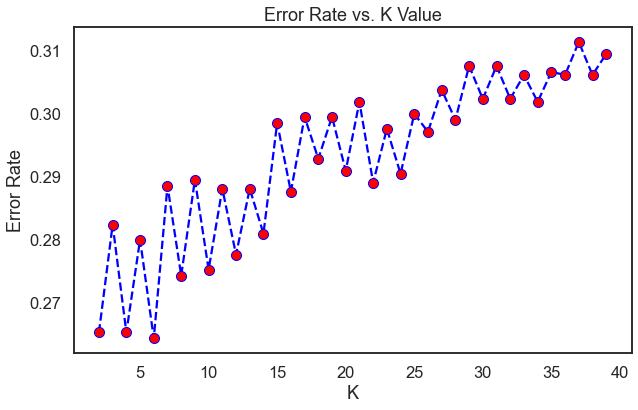

In [31]:
plt.figure(figsize=(10,6))
plt.plot(range(2,40),error_rate,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

by elbow method, the optimal K should be 4 or 6. 

Although the error rarte for k=4 & K=6 is almost the same and lowest among all K values, we will try K=4 & K=6

In [32]:
# NOW WITH K=4
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1549
           1       0.50      0.56      0.53       561

    accuracy                           0.73      2110
   macro avg       0.67      0.68      0.67      2110
weighted avg       0.74      0.73      0.74      2110



In [33]:
# NOW WITH K=6
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1549
           1       0.50      0.63      0.56       561

    accuracy                           0.74      2110
   macro avg       0.68      0.70      0.68      2110
weighted avg       0.76      0.74      0.74      2110



The recall score for KNN model (k=6) is 0.63. It is lower than the logistics regression model.

K=6 is better than K=4 in terms of recall. It may due to averaging more neighbour in a higher dimension screnrio generate a more general results which has higher recall.

## support vector machine

In [34]:
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

kwargs = {'kernel': 'rbf'}
svc = SVC(**kwargs)
nystroem = Nystroem(**kwargs)
sgd = SGDClassifier()

In [35]:
X_train_transformed = nystroem.fit_transform(X_train)
sgd.fit(X_train_transformed, y_train)

SGDClassifier()

In [36]:
X_test = nystroem.transform(X_test)
y_pred = sgd.predict(X_test)

In [37]:
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1549
           1       0.51      0.76      0.61       561

    accuracy                           0.75      2110
   macro avg       0.71      0.75      0.71      2110
weighted avg       0.79      0.75      0.76      2110

Accuracy score:  0.75
F1 Score:  0.61


By SVM method, the recall is 0.76, which is higher than 0.68 generated by logistics regression.

## model evaluation & insights

To recap:

simple logistics regression without penalty:
recall 0.68

KNN (k=6) :
recall 0.63

SVM:
recall 0.76

SVM show it performs the best among 3 models in terms of recall (i.e.0.76)

__Interpretation__

As SVM & KNN is un-interpretable on their variables. We will use logistics regression which shows the magnitude of its coefficient.

As the objective of the analysis is "Develop focused customer rentention program" to find out & keep as much customers who should be retented as possible. So find out the recall (true positive rate) is the most important evaluation metrics in this analysis.


In our dataset, all column are in 1/0 scale. the greater the coefficient, the larger impact it will have. From the coefficient list, we can observe that variable 'PhoneService_Yes' has coefficeint of 12.5, and 2 autopayment variables has that of -9.03 which are the top 3 highest absolute coefficient.

In human words, if a customer received the service with support (phone services), & paid automatically, he is less potentially be churned. The enterprise are suggested to create incentive to customer to make the payment automatically and provide a better customer phone service support to make the customers loyal, less chance to churn.

# Suggested-action for extra-mile

There are several ways to improve KNN & SVM models. 

Also, for SVM, we can optimize it by hyperparameter tuning for 'C' & 'gamma' to improve the model performance.

Moreover, for dataset, we can impute the missing values instead of dropping it, to keep as much data as possible. 

Furthermore, We can do the feature selection step to reduce the highly correlated features to reduce the model complexity while keeping the same performance, in view of curse of high dimensionality.